In [153]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from apyori import apriori
import math
import seaborn as sns

In [3]:
df = pd.read_csv('../../datasets/soccer_player_embeddings_v1.csv')
df.head(2)

,id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC12,PC13,PC14,player_fifa_api_id,player_api_id,overall_rating,potential,player_name,birthday,player_positions
0,97455,-0.020058,0.683692,-0.255270,-0.329416,-0.594869,0.124635,-0.209664,0.304167,-0.082228,...,0.047019,-0.091479,0.273118,119152,30831,78.0,78.0,Kolo Toure,1981-03-19 00:00:00,CB
1,42881,0.068503,0.188564,-0.228424,-0.542123,-0.304828,0.015172,0.001972,-0.151031,-0.113127,...,-0.188535,0.258280,-0.195703,199284,133126,63.0,63.0,Dennis Hediger,1986-09-22 00:00:00,"CDM, CM, CAM"


In [3]:
def convert_to_list(position_str):
    new_str = position_str.replace(" ", "")
    new_str = new_str.split(",")
    return new_str

df['player_positions_list'] = df['player_positions'].apply(lambda x: convert_to_list(x))

In [4]:
df['player_positions_list'].value_counts()

[CB]                 805
[ST]                 630
[GK]                 561
[CDM, CM]            277
[LB]                 269
                    ... 
[CF, LW, RW]           1
[RM, RW, CM]           1
[LW, LM, RW]           1
[CAM, CM, RM, LW]      1
[LB, CM, CB, CDM]      1
Name: player_positions_list, Length: 539, dtype: int64

# Association Rule Mining

In [5]:
records = []
for i in range(0, len(df)):
    records.append(df['player_positions_list'][i])

In [22]:
association_rules = apriori(records, min_support=0.005, min_confidence=0.5, min_lift=3, min_length=2)
association_results = list(association_rules)

In [23]:
len(association_results)

5

In [54]:
association_results[0]

RelationRecord(items=frozenset({'CM', 'CDM'}), support=0.11953444479396036, ordered_statistics=[OrderedStatistic(items_base=frozenset({'CDM'}), items_add=frozenset({'CM'}), confidence=0.692167577413479, lift=3.31885479426463), OrderedStatistic(items_base=frozenset({'CM'}), items_add=frozenset({'CDM'}), confidence=0.5731523378582202, lift=3.3188547942646305)])

In [53]:
for item in association_results:

    #second index of the inner list
    support = str(item[1])
    
    #third index of the list located at 0th
    #of the third index of the inner list
    for stats in item[2]:
        print("Rule: {} --> {}".format(list(stats[0]), list(stats[1])))
        print("Support: " + support)
        print("Confidence: " + str(stats[2]))
        print("Lift: " + str(stats[3]))
        print("=====================================")

Rule: ['CDM'] --> ['CM']
Support: 0.11953444479396036
Confidence: 0.692167577413479
Lift: 3.31885479426463
Rule: ['CM'] --> ['CDM']
Support: 0.11953444479396036
Confidence: 0.5731523378582202
Lift: 3.3188547942646305
Rule: ['CAM', 'CDM'] --> ['CM']
Support: 0.01730103806228374
Confidence: 0.8461538461538461
Lift: 4.057199211045365
Rule: ['LM', 'CAM'] --> ['RM']
Support: 0.021075810003145644
Confidence: 0.5296442687747036
Lift: 3.668276972624799
Rule: ['RM', 'CAM'] --> ['LM']
Support: 0.021075810003145644
Confidence: 0.551440329218107
Lift: 3.8698207650868923
Rule: ['CM', 'CB'] --> ['CDM']
Support: 0.009122365523749607
Confidence: 0.8055555555555556
Lift: 4.664592187816232
Rule: ['RM', 'CDM'] --> ['CM']
Support: 0.0053475935828877
Confidence: 0.7727272727272727
Lift: 3.705128205128205


In [ ]:
for item in association_results:

    #second index of the inner list
    support = str(item[1])
    
    #third index of the list located at 0th
    #of the third index of the inner list
    for stats in item[2]:
        print("Rule: {} --> {}".format(list(stats[0]), list(stats[1])))
        print("Support: " + support)
        print("Confidence: " + str(stats[2]))
        print("Lift: " + str(stats[3]))
        print("=====================================")

# DBScan Clustering

In [126]:
X = df.iloc[:, 1:15]
y = df['player_positions']

In [170]:
labels = []
for l in y.values:
    if ',' in l:
        labels.extend(l.split(", "))
    else:
        labels.append(l)

labels, counts = np.unique(labels, return_counts=True)
for i, l in enumerate(labels):
    print("Position: {}, count {}".format(l, counts[i]))        

Position: CAM, count 887
Position: CB, count 1326
Position: CDM, count 1098
Position: CF, count 229
Position: CM, count 1326
Position: GK, count 561
Position: LB, count 754
Position: LM, count 906
Position: LW, count 357
Position: LWB, count 44
Position: RB, count 779
Position: RM, count 918
Position: RW, count 390
Position: RWB, count 29
Position: ST, count 1157


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(5086, 14)
(1272, 14)


### Find the optimal eps for DBScan using minPts = 28

In [138]:
def calculate_kn_distance(X, k):
    
    X = np.array(X)
    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(math.dist(X[i], X[j]))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])
    
    kn_distance.sort()
    
    return kn_distance

In [140]:
eps_dist = calculate_kn_distance(X_train, 28)

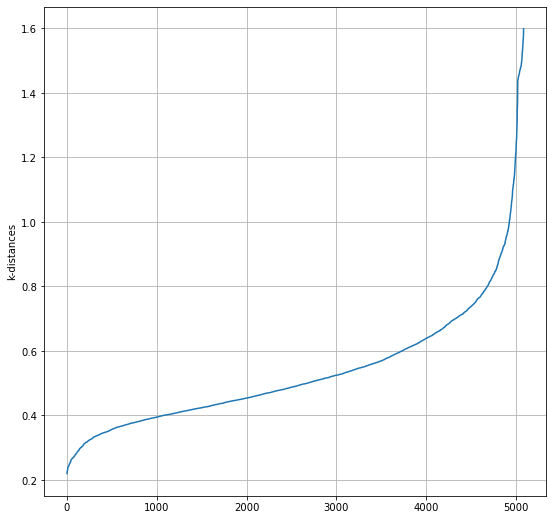

In [144]:
# Plot the Kth nearest neighrbour distance graph for all points
plt.figure(figsize =(9, 9))
plt.plot(eps_dist)
plt.ylabel("k-distances")
plt.grid(True)
plt.show()

In [145]:
# Use eps=1
db = DBSCAN(eps=1, min_samples=28, metric='euclidean').fit(X_train)

In [179]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

In [147]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train, db_labels))

Estimated number of clusters: 16
Estimated number of noise points: 65
Silhouette Coefficient: 0.398


In [176]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def silhouette_blob(samples, cluster_labels, n_clusters):
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(samples) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(samples, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(samples, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(samples[:, 0], samples[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

#         # Draw white circles at cluster centers
#         ax2.scatter(cluster_centres[:, 0], cluster_centres[:, 1], marker='o',
#                     c="white", alpha=1, s=200, edgecolor='k')

#         for i, c in enumerate(cluster_centres):
#             ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                         s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

For n_clusters = 16 The average silhouette_score is : 0.398074772769685


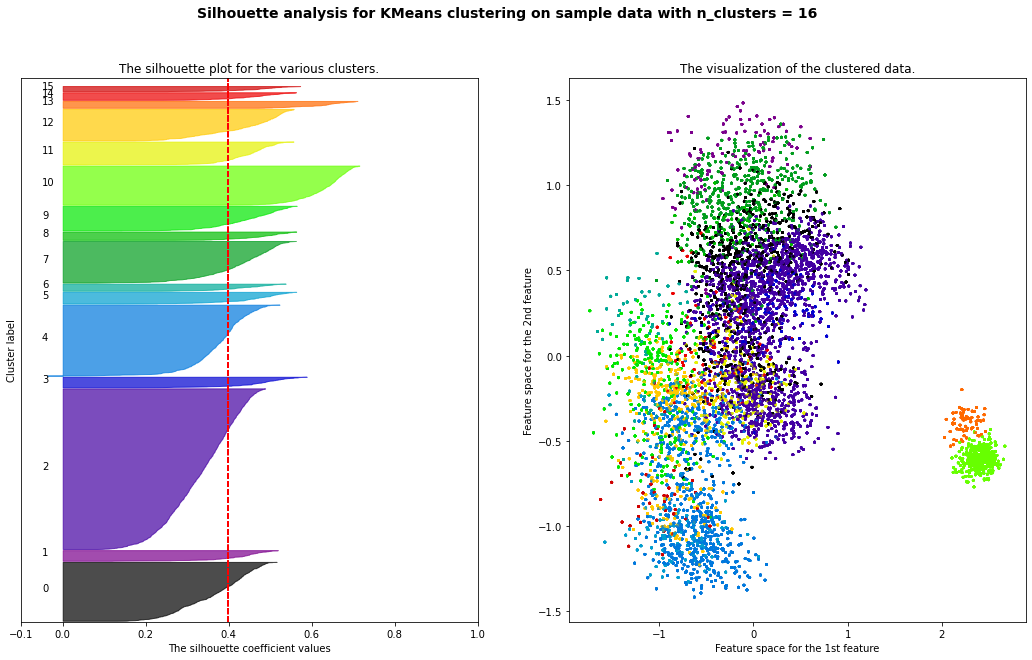

In [177]:
silhouette_blob(X_train.values, db.labels_, n_clusters_)

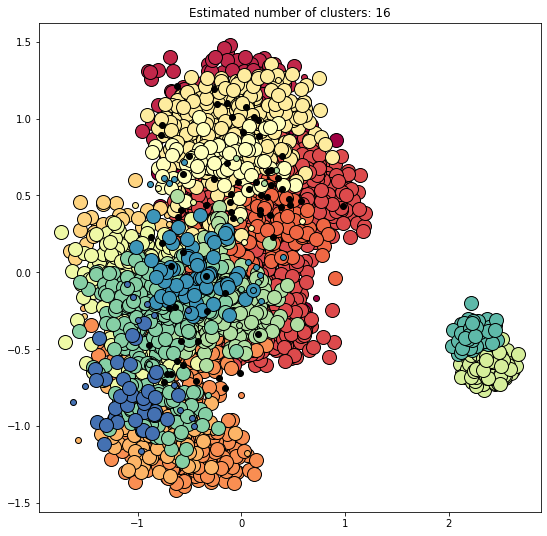

In [180]:
# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
plt.figure(figsize =(9, 9)) 
unique_labels = set(db_labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (db_labels == k)

    xy = X_train[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = X_train[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [168]:
def labels_in_cluster(given_cluster, num_clusters, title=None):
    y_train_vals = y_train.values
    classes_in_cluster = np.zeros(shape=(num_clusters, len(labels)), dtype=int)
    for i in range(num_clusters):
        dataInd = np.argwhere(given_cluster==i).flatten()
        for ind in dataInd:
            if ',' in y_train_vals[ind]:
                split = y_train_vals[ind].split(', ')
                for s in split:
                    j = np.where(labels == s)
                    classes_in_cluster[i][j] += 1
            else:
                j = np.where(labels == y_train_vals[ind])
                classes_in_cluster[i][j] += 1
    
    plt.figure(figsize=(15,5))
    if title:
        plt.title("Labels within clusters by {}".format(title))
    else:
        plt.title("Labels within clusters")
    sns.heatmap(classes_in_cluster, annot=True, cmap='Blues', fmt="d")
    plt.xticks([(i+0.5) for i in np.arange(len(labels))], labels=labels)
    plt.show()

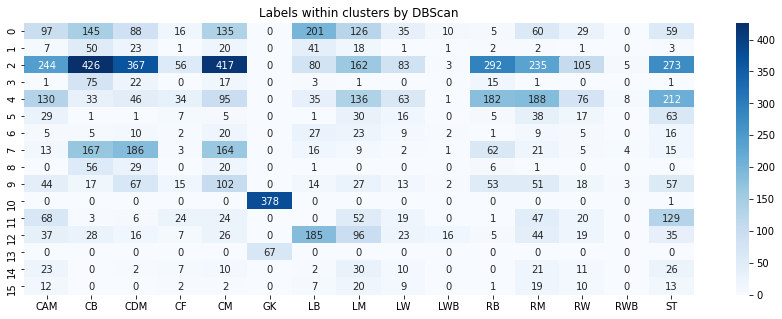

In [171]:
labels_in_cluster(db.labels_, n_clusters_, 'DBScan')